# Imports

In [1]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

import data_visualisation as dv
import data_augmentation as da


2024-05-29 20:09:08.978426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 20:09:09.478808: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-29 20:09:09.478866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-29 20:09:09.478873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Load the Data

In [2]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_1s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

# Augments

In [3]:
def mask_ecg(ecg, mask_ratio=0.1):
    block_size = 20
    
    for lead in range(ecg.shape[1]):
        for i in range(0, ecg.shape[0], block_size):
            if random.random() < mask_ratio:
                ecg[i:i+block_size, lead] = 0
    return ecg

def mask_lead(ecg, mask_ratio=0.1):

    for lead in range(ecg.shape[1]):
        if random.random() < mask_ratio:
            ecg[:, lead] = 0
    return ecg

In [4]:
def mask_ecg(ecg, mask_ratio=0.1, block_size=20):
    ecg_shape = tf.shape(ecg)
    num_blocks = ecg_shape[0] // block_size
    
    mask = tf.random.uniform([num_blocks, ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.reshape(tf.tile(mask[:, None, :], [1, block_size, 1]), ecg_shape)
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

def mask_lead(ecg, mask_ratio=0.1):
    ecg_shape = tf.shape(ecg)
    
    mask = tf.random.uniform([ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.tile(mask[None, :], [ecg_shape[0], 1])
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

In [5]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    res = mask_lead(noised_drifted_signal, mask_ratio=0.2)
    return res

# Train Loop (Unused atm)

In [6]:
def train_autoencoder(model, data, epochs=50, batch_size=32):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        steps = len(X_train) // batch_size
        for step, batch in enumerate(dataset):
            # augmented_batch = tf.map_fn(augment_ecg_signal, batch)

            with tf.GradientTape() as tape:
                reconstructed = model(batch, training=True)
                loss = loss_fn(batch, reconstructed)
            
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            print(f"\rEpoch {epoch+1}/{epochs}, Step {step}/{steps}, Loss: {loss.numpy():.4f}", end='')
        model.save(f'model-weights/autoencoder_{epoch+1}.h5')
        
        # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}')

# Auto Encoder

In [4]:
# Allow memory growth for the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-29 19:59:25.769022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-29 19:59:25.822427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-29 19:59:25.822630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [17]:
def encoder(inputs, latent_dim):
    # 100 x 12
    X = layers.Conv1D(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv1')(inputs)
    # 96 x 24
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 48 x 32
    X = layers.Conv1D(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv2')(X)
    # 44 x 48
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 22 x 48
    X = layers.Conv1D(64, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv3')(X)
    # 18 x 64
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 9 x 64
    X = layers.Flatten()(X)
    # 1152
    X = layers.Dense(latent_dim, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-encode')(X)
    # latent_dim
    return X

def decoder(latent_rep, latent_dim):
    X = layers.Dense(9*64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-decode')(latent_rep)
    # 1152
    X = layers.Reshape((9, 64))(X)
    # 9 x 64
    X = layers.UpSampling1D(2)(X)
    # 18 x 64
    X = layers.Conv1DTranspose(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv1')(X)
    # 22 x 48
    X = layers.UpSampling1D(2)(X)
    # 44 x 48
    X = layers.Conv1DTranspose(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv2')(X)
    # 48 x 24
    X = layers.UpSampling1D(2)(X)
    # 96 x 24
    X = layers.Conv1DTranspose(12, 5, activation='linear', padding='valid', name='upconv3')(X)
    # 100 x 12
    return X

def make_model(inputs, latent_dim):
    latent_rep = encoder(inputs, latent_dim)
    X = decoder(latent_rep, latent_dim)
    return keras.Model(inputs=inputs, outputs=X)
    
inputs = keras.Input(shape=X_train.shape[1:])
model = make_model(inputs, latent_dim=256)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 96, 24)            1464      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 48, 24)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 48, 24)            0         
                                                                 
 conv2 (Conv1D)              (None, 44, 48)            5808      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 22, 48)           0         
 g1D)                                                      

In [4]:
# Split the data into training and validation sets
validation_split = 0.2
num_val_samples = int(validation_split * len(X_train))
num_train_samples = len(X_train) - num_val_samples

X_train_data = X_train[:num_train_samples]
X_val_data = X_train[num_train_samples:]

# Create tf.data.Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_data, X_train_data))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_data, X_val_data))

In [5]:
# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [6]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2024-05-29 20:09:33.493056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-29 20:09:34.334329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-29 20:09:34.380930: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x741a66300540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-29 20:09:34.380949: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-29 20:09:34.384813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-29 20:09:34.459693: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

5744/5744 [==============================] - 37s 6ms/step - loss: 0.0161 - val_loss: 0.0168
Epoch 2/10
5744/5744 [==============================] - 34s 6ms/step - loss: 0.0247 - val_loss: 0.0228
Epoch 3/10
5744/5744 [==============================] - 35s 6ms/step - loss: 0.0176 - val_loss: 0.0128
Epoch 4/10
5744/5744 [==============================] - 33s 6ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 5/10
5744/5744 [==============================] - 33s 6ms/step - loss: 0.0183 - val_loss: 0.0186
Epoch 6/10
5744/5744 [==============================] - 34s 6ms/step - loss: 0.0181 - val_loss: 0.0148
Epoch 7/10
5744/5744 [==============================] - 34s 6ms/step - loss: 0.0162 - val_loss: 0.0125
Epoch 8/10
5744/5744 [==============================] - 34s 6ms/step - loss: 0.0178 - val_loss: 0.0154
Epoch 9/10
5744/5744 [==============================] - 34s 6ms/step - loss: 0.0178 - val_loss: 0.0183
Epoch 10/10
5744/5744 [==============================] - 34s 6ms/step - loss: 0.0160

# Testing

1/1 [==============================] - 0s 14ms/step


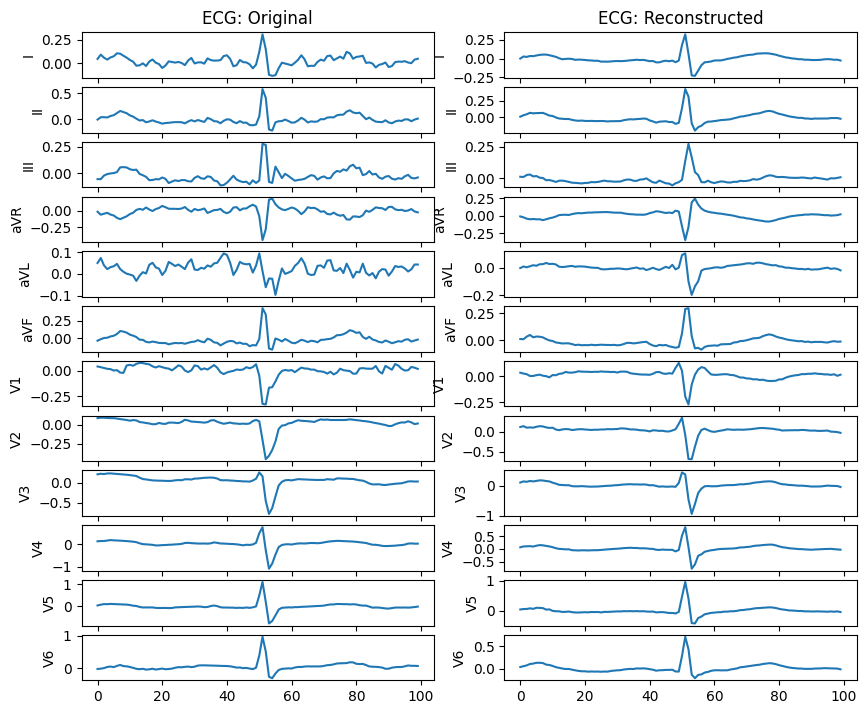

In [10]:
# get a random sample
idx = random.randint(0, X_train.shape[0])
sample = X_train[idx]
# augmented_sample = augment_ecg_signal(sample)
# print(sample.shape, augmented_sample.shape)
# reconstructed_sample = model.predict(augmented_sample[None, ...])[0]
# print(reconstructed_sample.shape)
reconstructed_sample = model.predict(sample[None, ...])[0]

# dv.plot_12_lead_ecgs([sample, augmented_sample, reconstructed_sample], ['Original', 'Augmented', 'Reconstructed'])
dv.plot_12_lead_ecgs([sample, reconstructed_sample], ['Original', 'Reconstructed'])

# Save the Model

In [11]:
model.save('temp/ae2.h5')

# TSNE

In [25]:
inputs = keras.Input(shape=X_train.shape[1:])
enc = encoder(inputs, latent_dim=256)
encoder_model = keras.Model(inputs=inputs, outputs=enc)

encoder_model.load_weights('temp/ae2.h5', by_name=True)

(1000, 100, 12)
(1000, 256)


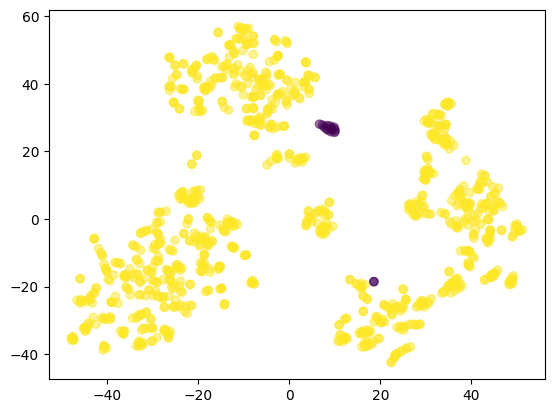

In [30]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    print(representations.shape)
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.show()


labels_Norm = [0 if "HYP" in x else 1 for x in Y_train_text[:1000]]
# labels_Norm = [1 if "NORM" in x else 0 for x in Y_train_text[:1000]]
# labels_Norm = [0 if len(x)==0 else 1 for x in Z_HB_text[:1000]]
print(X_train[:1000].shape)


plot_tsne(encoder_model, X_train[:1000], labels=labels_Norm)